# BUILD Heteregoneus Graph

In [1]:
from src.preprocessing import DataPreprocessor

df= DataPreprocessor.read_csv('abstract_embeddings.csv')

Loaded dataset from 'abstract_embeddings.csv'.


In [2]:
df.head()

,abstract,authors,n_citation,references,year,id,venue_numeric,filtered_references,abstract_embeddings
0,Title: A new approach of 3D watermarking based...,"['S. Ben Jabra', 'Ezzeddine Zagrouba']",50,"['09cb2d7d-47d1-4a85-bfe5-faa8221e644b', '10aa...",2008,4ab3735c-80f1-472d-b953-fa0557fed28b,0,"['661a342e-a911-4420-b67d-51c75d3b14e9', '7795...","[-0.029274752363562584, 0.06932459026575089, 6..."
1,Title: Attractor neural networks with activity...,"['Joaquín J. Torres', 'Jesús M. Cortés', 'Joaq...",50,"['4017c9d2-9845-4ad2-ad5b-ba65523727c5', 'b118...",2007,4ab39729-af77-46f7-a662-16984fb9c1db,1,"['b1187381-cc24-471e-b288-5da09c3d4ca9', 'ecf8...","[-0.03444525972008705, -0.12327978760004044, -..."
2,Title: Exploring the space of a human action\n...,"['Yaser Sheikh', 'Mumtaz Sheikh', 'Mubarak Shah']",221,"['056116c1-9e7a-4f9b-a918-44eb199e67d6', '05ac...",2005,4ab3a98c-3620-47ec-b578-884ecf4a6206,3,"['60cf9842-c3aa-463d-a5cf-17fbb8f99ccd', '7a3b...","[0.013628879562020302, -0.07601036876440048, 0..."
3,Title: Generalized upper bounds on the minimum...,"['Efraim Laksman', 'Håkan Lennerstad', 'Magnus...",0,"['01a765b8-0cb3-495c-996f-29c36756b435', '5dbc...",2015,4ab3b585-82b4-4207-91dd-b6bce7e27c4e,4,"['5dbc8ccb-0014-4cb8-b720-e2a5b44b671d', '79c9...","[-0.07133849710226059, 0.05011015385389328, -0..."
4,Title: Applying BCMP multi-class queueing netw...,"['Simonetta Balsamo', 'Gian–Luca Dei Rossi', '...",6,"['1c26e228-57d2-4b2c-b0c9-8d5851c17fac', '7539...",2015,4ab3e768-78c9-4497-8b8e-9e934cb5f2e4,5,"['85244323-5e23-4e8b-86f5-7ac94efeb41a', '8feb...","[-0.06097082421183586, 0.003865320235490799, -..."


In [3]:
df = df.sort_values(by='year', ascending=True).head(100000)

In [4]:
df.shape

(100000, 9)

In [5]:
# df = df.sample(n=100000, random_state=42)


In [6]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import logging
import random
import matplotlib.pyplot as plt
import networkx as nx
import ast
import numpy as np

from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, HeteroConv
from torch_geometric.utils import negative_sampling
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class PaperGraph:
    """
    Builds a heterogeneous graph from a DataFrame.
    Ensures references are valid. Normalizes paper features.
    """
    def __init__(self, df):
        self.df = df
        self.build_graph()

    def build_graph(self):
        logger.info("Building HeteroData graph...")
        self.graph = HeteroData()
        paper_ids = list(self.df['id'].unique())
        author_set = set()
        for authors_list in self.df['authors']:
            author_set.update(authors_list)
        author_names = list(author_set)

        paper_index = {pid: i for i, pid in enumerate(paper_ids)}
        author_index = {author: i for i, author in enumerate(author_names)}

        paper_paper_edges = []
        author_paper_edges = []

        for _, row in self.df.iterrows():
            pid = row['id']
            if pid not in paper_index:
                continue
            paper_idx = paper_index[pid]

            if isinstance(row['filtered_references'], (list, tuple)):
                for ref_id in row['filtered_references']:
                    if ref_id in paper_index:
                        ref_idx = paper_index[ref_id]
                        paper_paper_edges.append((ref_idx, paper_idx))

            if isinstance(row['authors'], (list, tuple)):
                for author in row['authors']:
                    if author in author_index:
                        auth_idx = author_index[author]
                        author_paper_edges.append((auth_idx, paper_idx))

        self.graph['paper'].num_nodes = len(paper_ids)
        self.graph['author'].num_nodes = len(author_names)

        if len(paper_paper_edges) > 0:
            self.graph['paper','cites','paper'].edge_index = \
                torch.tensor(paper_paper_edges, dtype=torch.long).t().contiguous()
        else:
            self.graph['paper','cites','paper'].edge_index = torch.empty((2, 0), dtype=torch.long)

        if len(author_paper_edges) > 0:
            self.graph['author','writes','paper'].edge_index = \
                torch.tensor(author_paper_edges, dtype=torch.long).t().contiguous()
        else:
            self.graph['author','writes','paper'].edge_index = torch.empty((2, 0), dtype=torch.long)

        # Build paper node features
        logger.info("Building paper feature matrix...")
        def to_float_tensor(arr_or_str):
            if isinstance(arr_or_str, str):
                arr_or_str = ast.literal_eval(arr_or_str)
            return torch.tensor(arr_or_str, dtype=torch.float)

        n_citation_col = self.df['n_citation'].astype(float).values
        venue_col = self.df['venue_numeric'].astype(float).values
        emb_list = self.df['abstract_embeddings'].apply(to_float_tensor).tolist()

        n_citation_tensor = torch.tensor(n_citation_col, dtype=torch.float).unsqueeze(-1)
        venue_tensor = torch.tensor(venue_col, dtype=torch.float).unsqueeze(-1)

        emb_stack = torch.stack(emb_list, dim=0)
        paper_features = torch.cat([n_citation_tensor, venue_tensor, emb_stack], dim=-1)
        paper_features = self._normalize_features(paper_features)
        self.graph['paper'].x = paper_features

        feat_dim = paper_features.shape[1]
        self.graph['author'].x = torch.zeros((len(author_names), feat_dim))

        logger.info("Graph building complete.")

    def _normalize_features(self, x):
        eps = 1e-9
        mean = x.mean(dim=0, keepdim=True)
        std = x.std(dim=0, keepdim=True) + eps
        return (x - mean) / std

    def get_graph(self):
        return self.graph

def split_edges(edge_index, val_ratio=0.1, test_ratio=0.1, seed=42):
    edges_count = edge_index.size(1)
    if edges_count == 0:
        logger.info("No edges to split.")
        return (
            torch.empty((2,0), dtype=torch.long),
            torch.empty((2,0), dtype=torch.long),
            torch.empty((2,0), dtype=torch.long)
        )

    torch.manual_seed(seed)
    edges_arr = list(zip(edge_index[0].tolist(), edge_index[1].tolist()))
    random.seed(seed)
    random.shuffle(edges_arr)
    E = len(edges_arr)
    n_val = int(E * val_ratio)
    n_test = int(E * test_ratio)
    val_edges = edges_arr[:n_val]
    test_edges = edges_arr[n_val:n_val+n_test]
    train_edges = edges_arr[n_val+n_test:]

    def to_tensor(e):
        if not e:
            return torch.empty((2,0), dtype=torch.long)
        return torch.tensor(e, dtype=torch.long).t().contiguous()

    return to_tensor(train_edges), to_tensor(val_edges), to_tensor(test_edges)

def get_edge_label_index_and_label(data, edge_type, pos_edge_index, num_neg_samples=None):
    E_pos = pos_edge_index.size(1)
    if E_pos == 0:
        logger.info("No positive edges found for label creation.")
        return pos_edge_index, torch.empty(0, dtype=torch.float)
    if num_neg_samples is None:
        num_neg_samples = E_pos

    neg_edge_index = negative_sampling(
        edge_index=data[edge_type].edge_index,
        num_nodes=data['paper'].num_nodes,
        num_neg_samples=num_neg_samples,
        method='sparse'
    )
    edge_label_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
    edge_label = torch.cat([
        torch.ones(E_pos),
        torch.zeros(neg_edge_index.size(1))
    ], dim=0)
    return edge_label_index, edge_label

def visualize_subgraph(data, num_papers=5):
    paper_edges = data['paper','cites','paper'].edge_index
    if paper_edges.size(1) == 0:
        logger.info("No paper->paper edges found. Skipping subgraph visualization.")
        return
    G = nx.DiGraph()
    all_papers = torch.arange(data['paper'].num_nodes)
    chosen = random.sample(all_papers.tolist(), min(num_papers, data['paper'].num_nodes))
    chosen_set = set(chosen)

    for p in chosen:
        G.add_node(f"paper_{p}", node_type='paper')
        mask = (paper_edges[1] == p)
        for s in paper_edges[0][mask].tolist():
            if s in chosen_set:
                G.add_node(f"paper_{s}", node_type='paper')
                G.add_edge(f"paper_{s}", f"paper_{p}")
    author_edges = data['author','writes','paper'].edge_index
    for a, p in zip(author_edges[0].tolist(), author_edges[1].tolist()):
        if p in chosen_set:
            a_node = f"author_{a}"
            p_node = f"paper_{p}"
            if not G.has_node(a_node):
                G.add_node(a_node, node_type='author')
            if G.has_node(p_node):
                G.add_edge(a_node, p_node)

    colors = []
    for node in G.nodes:
        if G.nodes[node]['node_type'] == 'paper':
            colors.append('steelblue')
        else:
            colors.append('tomato')
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8,6))
    nx.draw_networkx(G, pos, node_color=colors, with_labels=True, font_size=8, edge_color='gray')
    plt.title("Random Subgraph Visualization (Papers & Authors)")
    plt.axis('off')
    plt.show()

class GNNEncoder(nn.Module):
    def __init__(self, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = HeteroConv({
            ('paper','cites','paper'): SAGEConv((-1, -1), hidden_dim),
            ('paper','rev_writes','author'): SAGEConv((-1, -1), hidden_dim)
        }, aggr='sum')
        self.conv2 = HeteroConv({
            ('paper','cites','paper'): SAGEConv((hidden_dim, hidden_dim), out_dim),
            ('paper','rev_writes','author'): SAGEConv((hidden_dim, hidden_dim), out_dim)
        }, aggr='sum')

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k,v in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        return x_dict

class LinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.lin1 = nn.Linear(2 * in_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, 1)

    def forward(self, z_u, z_v):
        z = torch.cat([z_u, z_v], dim=-1)
        z = F.relu(self.lin1(z))
        return torch.sigmoid(self.lin2(z)).view(-1)

class CitationLinkModel(nn.Module):
    def __init__(self, hidden_dim, out_dim, link_hidden_dim):
        super().__init__()
        logger.info("Initializing CitationLinkModel...")
        self.encoder = GNNEncoder(hidden_dim, out_dim)
        self.link_predictor = LinkPredictor(out_dim, link_hidden_dim)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        z_paper = z_dict['paper']
        if edge_label_index.size(1) == 0:
            return torch.empty(0, dtype=torch.float)
        src = edge_label_index[0]
        dst = edge_label_index[1]
        z_u = z_paper[src]
        z_v = z_paper[dst]
        return self.link_predictor(z_u, z_v)

def train_link_predictor(model, data, train_edge_index, train_edge_label, optimizer):
    model.train()
    optimizer.zero_grad()
    if train_edge_index.size(1) == 0:
        return float('nan')
    out = model(data.x_dict, data.edge_index_dict, train_edge_index)
    if len(out) == 0:
        return float('nan')
    loss = F.binary_cross_entropy(out, train_edge_label)
    loss.backward()
    optimizer.step()
    return float(loss.item())

@torch.no_grad()
def test_link_predictor(model, data, edge_index, edge_label):
    model.eval()
    if edge_index.size(1) == 0:
        return float('nan'), float('nan'), None
    out = model(data.x_dict, data.edge_index_dict, edge_index)
    if len(out) == 0:
        return float('nan'), float('nan'), None
    loss = F.binary_cross_entropy(out, edge_label)
    pred = (out > 0.5).float()
    acc = (pred == edge_label).float().mean()
    return float(loss.item()), float(acc.item()), pred

def recommend_citations(model, data, paper_idx, k=5):
    model.eval()
    with torch.no_grad():
        z_dict = model.encoder(data.x_dict, data.edge_index_dict)
        z_paper = z_dict['paper']
    num_papers = data['paper'].num_nodes
    if num_papers < 2:
        return [], []
    candidates = []
    for i in range(num_papers):
        if i != paper_idx:
            candidates.append(i)
    src = torch.tensor(candidates, dtype=torch.long)
    dst = torch.full_like(src, paper_idx)
    z_u = z_paper[src]
    z_v = z_paper[dst]
    link_probs = model.link_predictor(z_u, z_v)
    sorted_idx = torch.argsort(link_probs, descending=True)
    top_idx = sorted_idx[:k]
    return src[top_idx].tolist(), link_probs[top_idx].tolist()

def plot_confusion_matrix(y_true, y_pred):
    if y_true.numel() == 0:
        logger.info("No edges to plot in confusion matrix.")
        return
    cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def visualize_embeddings(model, data):
    model.eval()
    with torch.no_grad():
        z_dict = model.encoder(data.x_dict, data.edge_index_dict)
        z_paper = z_dict['paper']
    if z_paper.size(1) < 2:
        logger.info("Embedding dimension < 2; skipping PCA.")
        return
    pca = PCA(n_components=2)
    z_2d = pca.fit_transform(z_paper.cpu().numpy())
    plt.figure(figsize=(6,5))
    plt.scatter(z_2d[:,0], z_2d[:,1], s=30, alpha=0.7, c='blue')
    plt.title("Paper Embeddings (PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

def run_link_prediction_training(
    data,
    train_edge_index, train_edge_label,
    val_edge_index, val_edge_label,
    test_edge_index, test_edge_label,
    hidden_dim=32, out_dim=32, link_hidden_dim=32,
    epochs=10, lr=0.001
):
    model = CitationLinkModel(hidden_dim, out_dim, link_hidden_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses, val_accs = [], [], []

    logger.info("Starting training...")
    for epoch in tqdm(range(1, epochs+1), desc="Training epochs"):
        train_loss = train_link_predictor(model, data, train_edge_index, train_edge_label, optimizer)
        val_loss, val_acc, _ = test_link_predictor(model, data, val_edge_index, val_edge_label)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        logger.info(f"Epoch {epoch:02d} | train_loss={train_loss} | val_loss={val_loss} | val_acc={val_acc}")

    test_loss, test_acc, test_pred = test_link_predictor(model, data, test_edge_index, test_edge_label)
    logger.info(f"Final Test | test_loss={test_loss} | test_acc={test_acc}")

    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), train_losses, label="Train Loss", marker='o')
    plt.plot(range(1, epochs+1), val_losses, label="Val Loss", marker='s')
    plt.title("Training/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("BCE Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), val_accs, label="Val Accuracy", marker='^')
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, test_pred

INFO:__main__:======= LOADING YOUR DATAFRAME (df) =======
INFO:__main__:Building HeteroData graph...
INFO:__main__:Building paper feature matrix...
INFO:__main__:Graph building complete.
INFO:__main__:Visualizing a small subgraph before splitting edges.
INFO:__main__:No paper->paper edges found. Skipping subgraph visualization.
INFO:__main__:Splitting edges into train/val/test.
INFO:__main__:No edges to split.
INFO:__main__:Setting adjacency to train-only edges.
INFO:__main__:Creating train, val, test edge_label_index/label with negative sampling.
INFO:__main__:No positive edges found for label creation.
INFO:__main__:No positive edges found for label creation.
INFO:__main__:No positive edges found for label creation.
INFO:__main__:Starting training.
INFO:__main__:Initializing CitationLinkModel...
INFO:__main__:Starting training...
Training epochs:   0%|          | 0/10 [00:00<?, ?it/s]INFO:__main__:Epoch 01 | train_loss=nan | val_loss=nan | val_acc=nan
INFO:__main__:Epoch 02 | train_l

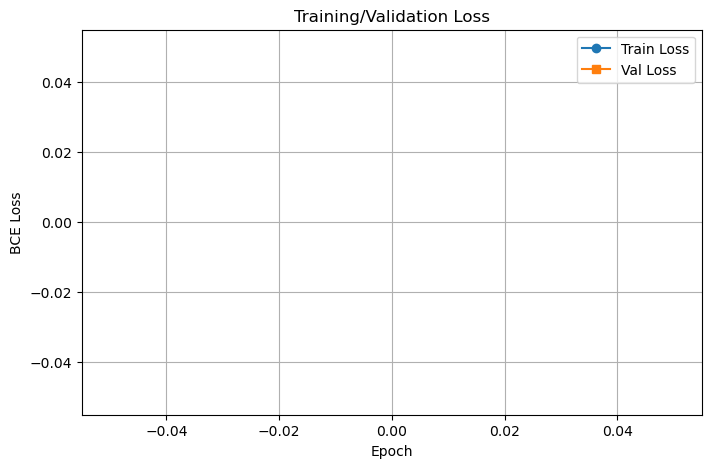

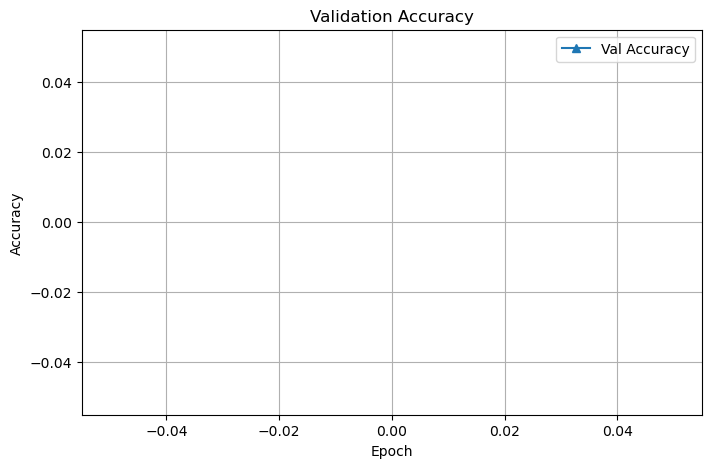

INFO:__main__:Visualizing final paper embeddings (PCA).


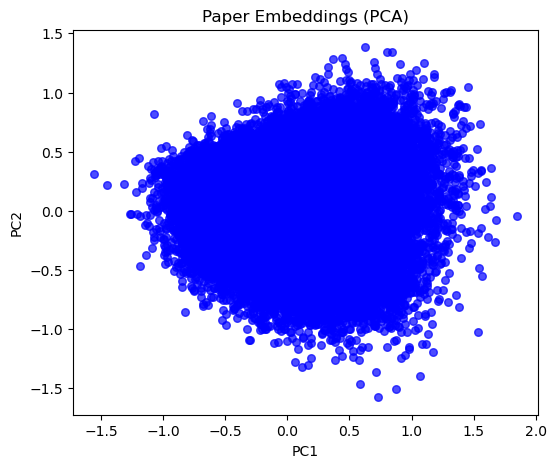

INFO:__main__:Recommended citing papers for paper 0: [71582, 87623, 96147] with scores [0.5202249884605408, 0.5199083089828491, 0.5197779536247253].
INFO:__main__:Done.


: 

In [7]:

logger.info("======= LOADING YOUR DATAFRAME (df) =======")
# Ensure your df has columns: 
#   id, authors, filtered_references, n_citation, venue_numeric, abstract_embeddings
# If references do not match 'id', adjacency will be empty => leads to NaNs.

# 1) Suppose 'df' is already in your namespace; otherwise, load or define it.
# df = pd.read_csv("my_data.csv")  # Example

# 2) Build the graph
graph_builder = PaperGraph(df)
data = graph_builder.get_graph()

# Check if we have any edges at all
pp_size = data['paper','cites','paper'].edge_index.size(1)
if pp_size == 0:
    logger.warning("No valid paper->paper edges found. Exiting to avoid NaN.")
    exit()

logger.info("Visualizing a small subgraph before splitting edges.")
visualize_subgraph(data, num_papers=3)

# 3) Split edges
logger.info("Splitting edges into train/val/test.")
full_edge_index = data['paper','cites','paper'].edge_index
train_edges, val_edges, test_edges = split_edges(full_edge_index, val_ratio=0.2, test_ratio=0.2)

logger.info("Setting adjacency to train-only edges.")
data['paper','cites','paper'].edge_index = train_edges

# 4) Negative sampling
logger.info("Creating train, val, test edge_label_index/label with negative sampling.")
train_edge_index, train_edge_label = get_edge_label_index_and_label(data, ('paper','cites','paper'), train_edges)
val_edge_index, val_edge_label = get_edge_label_index_and_label(data, ('paper','cites','paper'), val_edges)
test_edge_index, test_edge_label = get_edge_label_index_and_label(data, ('paper','cites','paper'), test_edges)

# 5) Train
logger.info("Starting training.")
model, test_pred = run_link_prediction_training(
    data,
    train_edge_index, train_edge_label,
    val_edge_index, val_edge_label,
    test_edge_index, test_edge_label,
    hidden_dim=16, out_dim=16, link_hidden_dim=16,
    epochs=10, lr=0.01
)

# 6) Visualize results
logger.info("Visualizing final paper embeddings (PCA).")
visualize_embeddings(model, data)

if test_edge_label.numel() > 0 and test_pred is not None:
    logger.info("Plotting confusion matrix on test set.")
    plot_confusion_matrix(test_edge_label, test_pred)

# 7) Demonstrate citation recommendation
if data['paper'].num_nodes > 1:
    rec_papers, rec_scores = recommend_citations(model, data, paper_idx=0, k=3)
    logger.info(f"Recommended citing papers for paper 0: {rec_papers} with scores {rec_scores}.")

logger.info("Done.")


In [ ]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, Linear, to_hetero
from torch_geometric.loader import NeighborLoader
from sklearn.model_selection import train_test_split
import networkx as nx
import matplotlib.pyplot as plt
import random


class PaperGraph:
    """Builds a heterogeneous graph of papers (and authors) from a DataFrame."""
    def __init__(self, df):
        self.df = df
        self.build_graph()

    def build_graph(self):
        self.graph = HeteroData()

        paper_ids = list(self.df['id'].unique())
        author_names = list(set(author for authors in self.df['authors'] for author in authors))
        
        paper_index = {pid: i for i, pid in enumerate(paper_ids)}
        author_index = {author: i for i, author in enumerate(author_names)}
        
        paper_paper_edges = []
        author_paper_edges = []
        
        for _, row in self.df.iterrows():
            paper_id = row['id']
            paper_idx = paper_index[paper_id]
            for ref_id in row['filtered_references']:
                if ref_id in paper_index:  # only keep references existing in the dataset
                    paper_paper_edges.append((paper_index[ref_id], paper_idx))
            for author in row['authors']:
                if author in author_index:
                    author_paper_edges.append((author_index[author], paper_idx))
        

        self.graph['paper'].num_nodes = len(paper_ids)
        self.graph['author'].num_nodes = len(author_names)
        
        self.graph['paper', 'cites', 'paper'].edge_index = \
            torch.tensor(paper_paper_edges, dtype=torch.long).t().contiguous()
        
        self.graph['author', 'writes', 'paper'].edge_index = \
            torch.tensor(author_paper_edges, dtype=torch.long).t().contiguous()

        n_citation_tensor = torch.tensor(self.df['n_citation'].values, dtype=torch.float).unsqueeze(-1)
        venue_tensor = torch.tensor(self.df['venue_numeric'].values, dtype=torch.float).unsqueeze(-1)
        paper_x = torch.cat([n_citation_tensor, venue_tensor], dim=-1)
        self.graph['paper'].x = paper_x

        self.graph['paper'].y = n_citation_tensor.view(-1)
        
        self.graph['author'].x = torch.zeros((len(author_names), paper_x.shape[1]))

    def get_graph(self):
        return self.graph
    
    def visualize_graph(self, num_papers=5):
        """Optional: Nx visualization for a small random subset."""
        G = nx.DiGraph()
        sample_paper_ids = random.sample(list(self.df['id'].unique()), num_papers)

        for paper_id in sample_paper_ids:
            G.add_node(paper_id, node_type='paper', label=paper_id)
            
            refs = self.df.loc[self.df['id'] == paper_id, 'filtered_references'].values
            if len(refs) > 0:
                for ref_id in refs[0]:
                    if ref_id in self.df['id'].values:
                        G.add_edge(ref_id, paper_id)
           
            authors = self.df.loc[self.df['id'] == paper_id, 'authors'].values
            if len(authors) > 0:
                for author in authors[0]:
                    if author not in G.nodes:
                        G.add_node(author, node_type='author', label=author)
                    G.add_edge(author, paper_id)

        node_colors = {'paper': 'lightblue', 'author': 'lightcoral'}
        node_color_map = [node_colors.get(G.nodes[n].get('node_type', 'paper'), 'lightblue') for n in G.nodes]
        labels = {n: G.nodes[n].get('label', n) for n in G.nodes}

        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(G, seed=42)
        nx.draw(G, pos, node_color=node_color_map, labels=labels, with_labels=True,
                font_size=8, edge_color="gray", alpha=0.7)
        plt.title("Subgraph Visualization of Papers and Authors")
        plt.show()



In [ ]:
graph_builder = PaperGraph(df)
data = graph_builder.get_graph()
print(data)
graph_builder.visualize_graph()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, to_hetero
from torch_geometric.loader import NeighborLoader
from sklearn.model_selection import train_test_split

class CitationGNN(nn.Module):
    def __init__(self, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = HeteroConv({
            ('paper', 'cites', 'paper'): nn.Sequential(
                nn.Linear(-1, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            ),
            ('paper', 'rev_writes', 'author'): nn.Sequential(
                nn.Linear(-1, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            )
        }, aggr='sum')
        self.conv2 = HeteroConv({
            ('paper', 'cites', 'paper'): nn.Sequential(
                nn.Linear(hidden_dim, out_dim),
                nn.ReLU(),
                nn.Linear(out_dim, out_dim)
            ),
            ('paper', 'rev_writes', 'author'): nn.Sequential(
                nn.Linear(hidden_dim, out_dim),
                nn.ReLU(),
                nn.Linear(out_dim, out_dim)
            )
        }, aggr='sum')
        self.conv1_auth = HeteroConv({
            ('author', 'writes', 'paper'): nn.Sequential(
                nn.Linear(-1, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            )
        }, aggr='sum')
        self.conv2_auth = HeteroConv({
            ('author', 'writes', 'paper'): nn.Sequential(
                nn.Linear(hidden_dim, out_dim),
                nn.ReLU(),
                nn.Linear(out_dim, out_dim)
            )
        }, aggr='sum')
        self.lin_paper = nn.Linear(out_dim, 1)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k,v in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k,v in x_dict.items()}
        x_dict_auth = self.conv1_auth(x_dict, edge_index_dict)
        x_dict_auth = {k: F.relu(v) for k,v in x_dict_auth.items()}
        x_dict_auth = self.conv2_auth(x_dict_auth, edge_index_dict)
        x_dict_auth = {k: F.relu(v) for k,v in x_dict_auth.items()}
        x_dict.update(x_dict_auth)
        paper_out = self.lin_paper(x_dict['paper']).view(-1)
        return {'paper': paper_out, 'author': x_dict['author']}

def train_and_evaluate_gnn(data, epochs=5, hidden_dim=32, out_dim=16, batch_size=32):
    model = CitationGNN(hidden_dim, out_dim)
    model = to_hetero(model, data.metadata(), aggr='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    paper_indices = torch.arange(data['paper'].num_nodes)
    train_idx, test_idx = train_test_split(paper_indices, test_size=0.2, random_state=42)
    train_loader = NeighborLoader(
        data,
        input_nodes=('paper', train_idx),
        num_neighbors={
            ('paper', 'cites', 'paper'): [10, 10],
            ('paper', 'rev_writes', 'author'): [10, 10],
            ('author', 'writes', 'paper'): [10, 10],
        },
        shuffle=True,
        batch_size=batch_size
    )
    test_loader = NeighborLoader(
        data,
        input_nodes=('paper', test_idx),
        num_neighbors={
            ('paper', 'cites', 'paper'): [10, 10],
            ('paper', 'rev_writes', 'author'): [10, 10],
            ('author', 'writes', 'paper'): [10, 10],
        },
        shuffle=False,
        batch_size=batch_size
    )
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for batch_data in train_loader:
            optimizer.zero_grad()
            out = model(batch_data.x_dict, batch_data.edge_index_dict)['paper']
            loss = F.mse_loss(out, batch_data['paper'].y)
            loss.backward()
            optimizer.step()
            total_loss += float(loss)
        print(epoch, total_loss)
    model.eval()
    mse_list = []
    with torch.no_grad():
        for batch_data in test_loader:
            out = model(batch_data.x_dict, batch_data.edge_index_dict)['paper']
            mse_list.append(float(F.mse_loss(out, batch_data['paper'].y)))
    print(sum(mse_list)/len(mse_list))
    return model
